<a id="top"></a>
# Оптимизация работы предприятия золотодобывающей отрасли
<h4 align="right">Спринт 8 | Когорта ДС13 | Артур Урусов</h4>

<blockquote>
Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.
</blockquote>

## Содержание

0. **[Подготовка](#0)**

    0.1. [Импорт библиотек](#0-1)
    
    0.2. [Настройка окружения](#0-2)


1. **[Подготовка данных](#1)**

    1.1. [Чтение файлов](#1-1)
    
    1.2. [Проверка коэффициента обогащения](#1-2)
    
    1.3. [Какие признаки отсутствуют в тестовой выборке?](#1-3)
    
    1.4. [Предобработка данных](#1-4)
    

2. **[Анализ данных](#2)**

    2.1. [Концентрация металлов](#2-1)
    
    2.2. [Распределение размеров гранул сырья](#2-2)
    
    2.3. [Суммарная концентрация веществ на разных стадиях](#2-3)
    

3. **[Построение модели](#3)**

    3.1. [sMAPE](#3-1)
    
    3.2. [Настройка гиперпараметров](#3-2)
    
    3.3. [Проверка моделей на тестовой выборке](#3-3)
    

4. **[Результаты исследования](#4)**

    4.1. [Общие выводы](#4-1)
    
    4.2. [Чек-лист готовности проекта](#4-2)

<a id="0"></a>
## Этап 0. Подготовка

<a id="0-1"></a>
### Шаг 0.1 Импорт библиотек

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

[к началу шага](#0-1) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="0-2"></a>
### Шаг 0.2 Настройка окружения

In [2]:
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
STATE = 42

[к началу шага](#0-2) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="1"></a>
## Этап 1. Подготовка данных

<a id="1-1"></a>
### Шаг 1.1 Чтение файлов

Для начала сохраним данные из файлов в датафреймы. В качестве индекса используем столбец с отметками времени, так как по нему удобно связать данные из разных датафреймов.

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date')
test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date')
full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date')

Выведем информацию и первые пять строк каждого датафрейма:

In [4]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [5]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [6]:
full.info()
full.head()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

Расписывать полную структуру датафреймов не имеет особого смысла, поэтому бегло опишем данные:
- Всего четыре этапа:
  - флотация (`rougher`);
  - первичная и вторичная очистки (`primary_cleaner`, `secondary_cleaner`);
  - финальный продукт (`final`).
- На этих этапах также существуют группы параметров:
  - вход (`input`);
  - состояние (`state`);
  - расчётные (`calculation`);
  - выход (`output`).

Общее количество параметров довольно большое, однако нас будут интересовать всего два параметра: `rougher.output.recovery`, `final.output.recovery`. Именно эти параметры станут для нас целевыми.

Остальные параметры подробно описывать смысла нет, но мы вернемся к ним при необходимости.

[к началу шага](#1-1) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-2"></a>
### Шаг 1.2 Проверка коэффициента обогащения

Теперь проверим по имеющимся у нас данным правильность расчёта коэффициента восстановления для золота в тренировочной выборке.

Для этого воспользуемся следующей формулой ([источник](http://www.chem.mtu.edu/chem_eng/faculty/kawatra/Flotation_Fundamentals.pdf)):
$100 \times \frac{c (f - t)}{f (c - t)}$,
где: 
- **c** - `rougher.output.concentrate_au`,
- **f** - `rougher.input.feed_au`,
- **t** - `rougher.output.tail_au`.

Напишем для расчёта по этой формуле функцию:

In [7]:
def recovery_rate(feed, concentrate, tail):
    return 100 * (concentrate / feed) * (feed - tail) / (concentrate -  tail)

Применим её к нашим данным:

In [8]:
recovery = recovery_rate(train['rougher.input.feed_au'], 
                         train['rougher.output.concentrate_au'], 
                         train['rougher.output.tail_au'])
train_recovery = train['rougher.output.recovery'].dropna()

И вычислим MAE для результатов вычисления в сравнении с данными в таблице:

In [9]:
mae = mean_absolute_error(recovery[train_recovery.index], train_recovery)
print(f'MAE для {len(train_recovery)} значений из {len(recovery)}: {mae:,.2e}')

MAE для 14287 значений из 16860: 1.16e-14


Судя по значению ошибки, а точнее по степени первого значимого символа ($10^{-14}$), для вычисления коэффициента восстановления использовалась именно эта формула. Значения практически одинаковы, ошибок нет.

[к началу шага](#1-2) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-3"></a>
### Шаг 1.3 Какие признаки отсутствуют в тестовой выборке?

Разберёмся, какие же признаки отсутствуют в тестовой выборке. Для этого выведем на экран названия этих признаков:

In [10]:
extra_cols = [col for col in train.columns if col not in test.columns]
print(*extra_cols, sep='\n')

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

Как видим, тут две категории признаков: `output` и `calculation`. Их отсутствие в тестовой выборке логично, так как признаки вывода напрямую зависят от вводных данных и не могут быть известны заранее. Похожая ситуация и с категорией рассчитываемых признаков, ведь исходя из их названия, они рассчитываются из вводных данных.

[к началу шага](#1-3) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-4"></a>
### Шаг 1.4 Предобработка данных

Теперь нам нужно предобработать данные, в первую очередь разобраться с пропусками.

In [11]:
print(f'Размер тренировочной выборки: {train.shape}')
print(f'Размер тестовой выборки: {test.shape}')
print(f'Размер полной выборки: {full.shape}')
print(f'Пропущено значений в тренировочной выборке: {train.isnull().sum().sum()}')
print(f'Пропущено значений в тестовой выборке: {test.isnull().sum().sum()}')
print(f'Пропущено значений в полной выборке: {full.isnull().sum().sum()}')
print(f'Столбцов с пропущеными значениями в тренировочной выборке: {train.isnull().any(axis=1).sum()}')
print(f'Столбцов с пропущеными значениями в тестовой выборке: {test.isnull().any(axis=1).sum()}')
print(f'Столбцов с пропущеными значениями в полной выборке: {full.isnull().any(axis=1).sum()}')

Размер тренировочной выборки: (16860, 86)
Размер тестовой выборки: (5856, 52)
Размер полной выборки: (22716, 86)
Пропущено значений в тренировочной выборке: 30320
Пропущено значений в тестовой выборке: 2360
Пропущено значений в полной выборке: 36587
Столбцов с пропущеными значениями в тренировочной выборке: 5843
Столбцов с пропущеными значениями в тестовой выборке: 473
Столбцов с пропущеными значениями в полной выборке: 6622


Вообще, нам не требуется заполнять все значения, достаточно чтобы пропущенных значений не было в столбцах, необходимых для обучения. То есть для всех столбцов в тестовой выборке, а также для целевых признаков.

In [12]:
needed_columns = [*test.columns, 'rougher.output.recovery', 'final.output.recovery']

Теперь узнаем сколько строк заполнено в полной выборке:

In [13]:
good_full = full[needed_columns].notna().all(axis=1).sum()
print(f'Количество строк с полностью заполненными необходимыми признаками в полной выборке: {good_full}')
print(f'Процент строк с полностью заполненными необходимыми признаками в полной выборке: {good_full / len(full):,.2%}')

Количество строк с полностью заполненными необходимыми признаками в полной выборке: 17908
Процент строк с полностью заполненными необходимыми признаками в полной выборке: 78.83%


Проверим сколько строк с пропущенными целевыми признаками:

In [14]:
bad_full = full[['rougher.output.recovery', 'final.output.recovery']].isnull().any(axis=1).sum()
print(f'Количество строк с пропущенными целевыми признаками в полной выборке: {bad_full}')
print(f'Процент строк с пропущенными целевыми признаками в полной выборке: {bad_full / len(full):,.2%}')

Количество строк с пропущенными целевыми признаками в полной выборке: 3277
Процент строк с пропущенными целевыми признаками в полной выборке: 14.43%


Пропусков довольно много, но чтобы не вносить излишние помехи в данные, вместо заполнения целевых признаков мы избавимся от таких строк:

In [15]:
full = full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
bad_full = full[['rougher.output.recovery', 'final.output.recovery']].isnull().any(axis=1).sum()
print(f'Количество строк с пропущенными целевыми признаками в полной выборке: {bad_full}')

Количество строк с пропущенными целевыми признаками в полной выборке: 0


Так как в условии сказано, что: <blockquote>Соседние по времени параметры часто похожи.</blockquote>
Можем заполнить пропуски методом `ffill`:

In [16]:
full[needed_columns] = full[needed_columns].fillna(method='ffill')
print(f'Пропущено значений в полной выборке: {full[needed_columns].isnull().sum().sum()}')
print(f'Размер полной выборки: {full.shape}')

Пропущено значений в полной выборке: 0
Размер полной выборки: (19439, 86)


Теперь узнаем количество заполненных строк в тренировочной выборке.

In [17]:
good_train = train[needed_columns].notna().all(axis=1).sum()
print(f'Количество строк с полностью заполненными необходимыми признаками в тренировочной выборке: {good_train}')
print(f'Процент строк с полностью заполненными необходимыми признаками в тренировочной выборке: {good_train / len(train):,.2%}')

Количество строк с полностью заполненными необходимыми признаками в тренировочной выборке: 12679
Процент строк с полностью заполненными необходимыми признаками в тренировочной выборке: 75.20%


Так как тестовая выборка является частью полной выборки, а значения в ней могут не относиться к соседним временным промежуткам, мы не будем заполнять её самостоятельными значениями, а просто подгрузим данные из полной выборки.

In [18]:
train[needed_columns] = train[needed_columns].fillna(value=full)
train = train.loc[train.index.intersection(full.index)]
print(f'Пропущено значений в тренировочной выборке: {train[needed_columns].isnull().sum().sum()}')
print(f'Размер тренировочной выборки: {train.shape}')

Пропущено значений в тренировочной выборке: 0
Размер тренировочной выборки: (14149, 86)


С тестовой выборкой поступим аналогично:

In [19]:
good_test = test.notna().all(axis=1).sum()
print(f'Количество строк с полностью заполненными необходимыми признаками в тестовой выборке: {good_test}')
print(f'Процент строк с полностью заполненными необходимыми признаками в тестовой выборке: {good_test / len(test):,.2%}')

Количество строк с полностью заполненными необходимыми признаками в тестовой выборке: 5383
Процент строк с полностью заполненными необходимыми признаками в тестовой выборке: 91.92%


In [20]:
test = test.fillna(value=full)
test = test.loc[test.index.intersection(full.index)]
print(f'Пропущено значений в тестовой выборке: {test.isnull().sum().sum()}')
print(f'Размер тестовой выборки: {test.shape}')

Пропущено значений в тестовой выборке: 0
Размер тестовой выборки: (5290, 52)


[к началу шага](#1-4) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="2"></a>
## Этап 2. Анализ данных

Далее мы приступим к анализу данных.

<a id="2-1"></a>
### Шаг 2.1 Концентрация металлов

Для начала посмотрим, как изменяется концентрация металлов в зависимости от стадии обработки. Для этого напишем соответствующую функцию:

In [21]:
def concentrations(df, metal):
    plt.figure(figsize=(7, 5), dpi=80)
    plt.title(f'Концентрация {metal} на различных этапах очистки', fontsize=18, color='tab:blue')
    train[f'rougher.input.feed_{metal}'].plot(kind='hist', alpha=.6)
    train[f'rougher.output.concentrate_{metal}'].plot(kind='hist', alpha=.6)
    train[f'primary_cleaner.output.concentrate_{metal}'].plot(kind='hist', alpha=.6)
    train[f'final.output.concentrate_{metal}'].plot(kind='hist', alpha=.6)
    plt.legend(['rougher.input.feed',
                'rougher.output.concentrate', 
                'primary_cleaner.output.concentrate', 
                'final.output.concentrate'])
    plt.xlabel('Концентрация', fontsize=14, color='tab:blue')
    plt.ylabel('Частота', fontsize=14, color='tab:blue')
    plt.show()

Применим функцию на тренировочной выборке к каждому металлу:

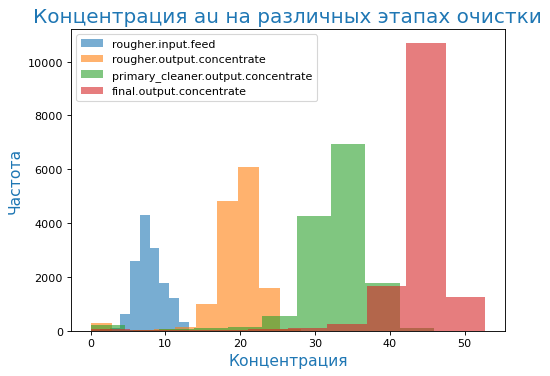

In [22]:
train_metals = concentrations(train, 'au')

Видим, что концентрация золота планомероно увеличивается с каждой стадией, это то что нам нужно, ведь основная цель процесса &mdash; увеличение концентрации золота.

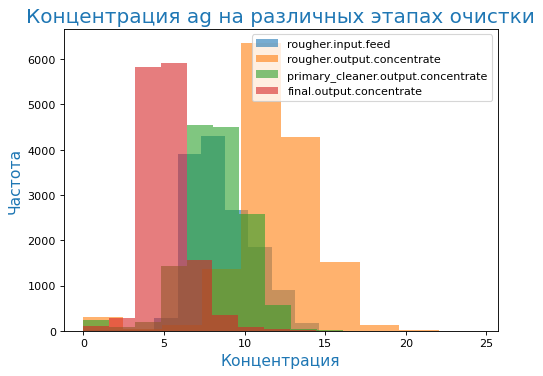

In [23]:
train_metals = concentrations(train, 'ag')

Для серебра характерно иное поведение: на этапе флотации его концентрация резко повышается, однако дальше, на этапах очистки, концентрация серебра снижается.

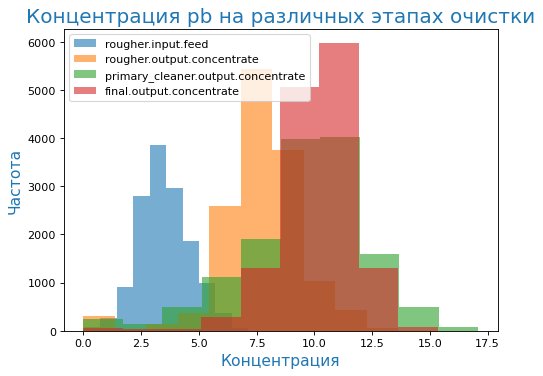

In [24]:
train_metals = concentrations(train, 'pb')

Концентрация свинца также увеличивается после флотации, затем на этапах очистки концентрация слегка растёт, а потом стабилизируется.

[к началу шага](#2-1) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-2"></a>
### Шаг 2.2 Распределение размеров гранул сырья

Следующим шагом будет сравнение тренировочной и тестовой выборок по распределению размеров гранул сырья. Если выборки будут подобными, то предсказания будут адекватными, а если выборки будут значительно отличаться, то оценка модели будет неправильной.

Построим графики распределения для наших выборок:

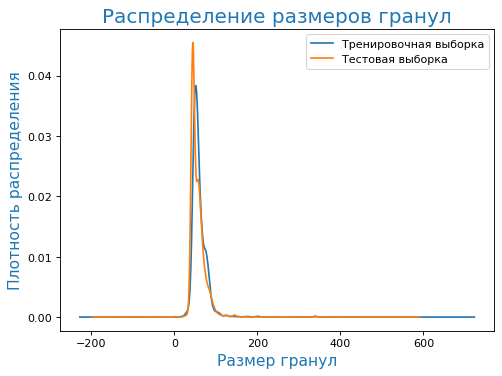

In [25]:
plt.figure(figsize=(7, 5), dpi=80)
plt.title('Распределение размеров гранул', fontsize=18, color='tab:blue')
train['rougher.input.feed_size'].plot(kind='kde')
test['rougher.input.feed_size'].plot(kind='kde')
plt.legend(['Тренировочная выборка', 'Тестовая выборка'])
plt.xlabel('Размер гранул', fontsize=14, color='tab:blue')
plt.ylabel('Плотность распределения', fontsize=14, color='tab:blue')
plt.show()

По графикам распределения видим, что по большей части выборки схожи. Есть некоторые отличия, самое заметное &mdash; более высокий пик у тестовой выборки. Также, у терноровочной выборки есть и выбивающиеся группы значений, а тестовая выборка сконцентрована в одной области.

[к началу шага](#2-2) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-3"></a>
### Шаг 2.3 Суммарная концентрация веществ на разных стадиях

Далее проверим сумму концентрации веществ на разных стадиях, для расчёта суммы напишем функцию:

In [26]:
def concentrations_sum(df, stages, cat):
    concentrations = pd.DataFrame()
    for stage in stages:
        concentrations[stage] = df[
            [col for col in df.columns if (f'{stage}' in col) and (f'{cat}' in col)]
        ].sum(axis=1)
    return concentrations

Теперь проверим суммарные концентрации на тренировочной выборке и выведем информацию на экран:

In [27]:
train_concs = concentrations_sum(train, ['rougher', 'primary_cleaner', 'final'], 'concentrate_')
round(train_concs.describe(), 2)

,rougher,primary_cleaner,final
count,14149.00,14149.00,14149.00
mean,67.14,60.03,68.34
std,12.77,10.62,7.07
min,0.00,0.00,0.00
25%,64.90,57.98,67.56
50%,69.17,61.75,69.14
75%,73.43,65.35,70.97
max,88.14,76.92,80.21


Также построим график распределения:

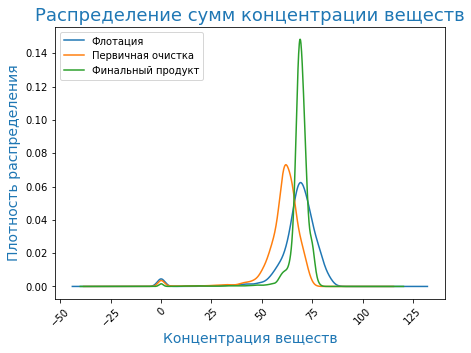

In [28]:
train_concs.plot(kind='kde', figsize=(7, 5))
plt.title('Распределение сумм концентрации веществ', fontsize=18, color='tab:blue')
plt.xticks(rotation=45)
plt.legend(['Флотация', 'Первичная очистка', 'Финальный продукт'])
plt.xlabel('Концентрация веществ', fontsize=14, color='tab:blue')
plt.ylabel('Плотность распределения', fontsize=14, color='tab:blue')
plt.show()

Видно, что помимо основного «колокола», на каждом этапе существует и малый «колокол» в районе нуля, при этом графики в этом месте практически совпадают, то есть скорее всего нули появляются сразу на всех этапах. Скорее всего это связано с техническими неполадками, и от таких значений следует избавиться.

Теперь проверим тестовую выборку. Так как столбцов с концентрациями в этой выборке нет, проверим выборку по вводным параметрам:

In [29]:
test_concs = concentrations_sum(train, ['rougher', 'primary_cleaner'], 'input')
round(test_concs.describe(), 2)

,rougher,primary_cleaner
count,14149.00,14149.00
mean,625.19,150.27
std,112.75,41.56
min,47.81,7.04
25%,565.60,123.04
50%,644.14,150.27
75%,701.20,177.63
max,1019.62,276.06


Также построим график распределения:

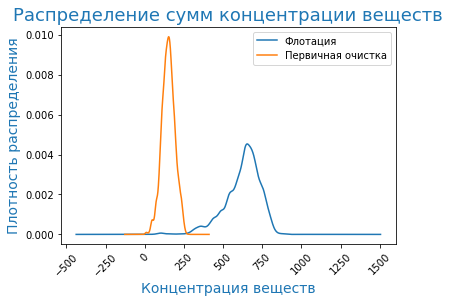

In [30]:
test_concs.plot(kind='kde')
plt.title('Распределение сумм концентрации веществ', fontsize=18, color='tab:blue')
plt.xticks(rotation=45)
plt.legend(['Флотация', 'Первичная очистка'])
plt.xlabel('Концентрация веществ', fontsize=14, color='tab:blue')
plt.ylabel('Плотность распределения', fontsize=14, color='tab:blue')
plt.show()

Видим, что хоть распределения хоть и имеют несколько пиков, странных нулевых значений нет, так что больших вопросов это не вызывает. Вероятно в этой выборке пока можно оставить все данные.

Напишем функцию для очистки выборки:

In [31]:
def drop_bad_values(df, stages, cat, threshold=1):
    raw = concentrations_sum(df, stages, cat)
    for col in raw.columns:
        raw[col] = raw[col] < threshold 
    drop_index = raw[raw.any(axis=1)]
    print(f'Найдено плохих значений: {len(drop_index)}.')
    answer = input('Удалить плохие значения? (Y / n) ')
    if answer.lower() == 'y':
        clean = df.drop(drop_index.index)
        print(f'Удалено плохих значений: {len(drop_index)}.')
        print(f'Размер выборки после очистки: {len(clean)}.')
        return clean
    else:
        print('Отменено.')
        return None

Очистим тренировочную выборку:

In [32]:
clean_train = drop_bad_values(train, ['rougher', 'primary_cleaner', 'final'], 'concentrate_')

Найдено плохих значений: 550.
Удалить плохие значения? (Y / n) y
Удалено плохих значений: 550.
Размер выборки после очистки: 13599.


И взглянем на графики распределения очищенной тренировочной выборки:

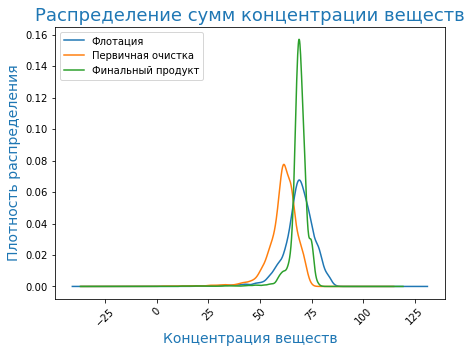

In [33]:
clean_train_concs = concentrations_sum(clean_train, ['rougher', 'primary_cleaner', 'final'], 'concentrate_')
clean_train_concs.plot(kind='kde', figsize=(7, 5))
plt.title('Распределение сумм концентрации веществ', fontsize=18, color='tab:blue')
plt.xticks(rotation=45)
plt.legend(['Флотация', 'Первичная очистка', 'Финальный продукт'])
plt.xlabel('Концентрация веществ', fontsize=14, color='tab:blue')
plt.ylabel('Плотность распределения', fontsize=14, color='tab:blue')
plt.show()

Видно, что от пика в районе нуля мы успешно избавились.

[к началу шага](#2-3) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="3"></a>
## Этап 3. Построение модели

Теперь приступим к подбору и обучению моделей для предсказания коэффициентов восстановления.

<a id="3-1"></a>
### Шаг 3.1     sMAPE

На первом этапе напишем функции для расчета sMAPE по формуле из условия:
$$sMAPE = \frac{1}{N}\sum_{i = 1}^{N}\frac{\left | y_{i} - \hat{ y_{i} } \right |}{(\left | y_{i} \right | + \left | \hat{ y_{i} } \right |) / 2} \times 100%$$

In [34]:
def sMAPE(y, y_pred):
    if len(y) == len(y_pred):
        return sum(np.absolute(y_pred - y) / ((np.absolute(y_pred) + np.absolute(y)) / 2)) / len(y_pred)
    else:
        raise ValueError(f'Found input variables with inconsistent numbers of samples: {[len(y_pred), len(y)]}')

Затем, по формуле из условия напишем функцию для расчёта итогового sMAPE:

$$ sMAPE_{ (total) } = 25\% \times sMAPE_{ (rougher) } + 75\% \times sMAPE_{ (final) } $$

In [35]:
def total_sMAPE(y, y_pred):
    return .25 * sMAPE(y[:,0], y_pred[:,0]) + .75 * sMAPE(y[:,1], y_pred[:,1])

Сделаем функцию оценки из нашей функции с помощью `make_scorer`:

In [36]:
sMAPE_scorer = make_scorer(total_sMAPE, greater_is_better=False)

[к началу шага](#3-1) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-2"></a>
### Шаг 3.2 Настройка гиперпараметров

<a id="change_1"></a>
Теперь перейдём к подбору гиперпараметров. Для обучения выберем три модели: `Ridge`, `DecisionTreeRegressor`, `RandomForestRegressor`. Так как выборки уже предварительно разделены, делать нам этого не нужно. Поэтому просто разделим тренировочную выборку на `features` и `target`:

In [37]:
X = np.array(clean_train.drop(extra_cols, axis=1))
print(X.shape)
y = np.array(clean_train[['rougher.output.recovery', 'final.output.recovery']])
print(y.shape)

(13599, 52)
(13599, 2)


Теперь напишем функцию для подбора гиперпараметров:

In [38]:
def best_grid(model, grid, X, y, n_jobs=-1, cv=5):
    grid_cv = GridSearchCV(model, grid, scoring=sMAPE_scorer, n_jobs=n_jobs, cv=cv)
    grid_cv.fit(X, y)

    print('Best sMAPE: {:,.2%}'.format(-1 * grid_cv.best_score_))
    print('Best Hyperparameters: \n{}'.format(grid_cv.best_params_))
    return grid_cv.best_params_

Подберём лучшие гиперпараметры для `Ridge`:

In [39]:
%%time

lrm = Ridge(random_state=STATE)
lrm_grid = {
    'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept': [True, False],
    'normalize': [True, False],
}
lrm_params = best_grid(lrm, lrm_grid, X, y)

Best sMAPE: 8.45%
Best Hyperparameters: 
{'alpha': 1, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
Wall time: 1min 43s


Для `DecisionTreeRegressor`:

In [40]:
%%time

dtm = DecisionTreeRegressor(random_state=STATE)
dtm_grid = {
    'criterion': ['mse', 'friedman_mse', 'poisson'],
    'min_samples_split': [10, 20, 40],
    'max_depth': [2, 6, 8],
    'min_samples_leaf': [20, 40, 100],
    'max_leaf_nodes': [5, 20, 100],
}
dtm_params = best_grid(dtm, dtm_grid, X, y)

Best sMAPE: 9.08%
Best Hyperparameters: 
{'criterion': 'friedman_mse', 'max_depth': 6, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_split': 10}
Wall time: 18.9 s


И для `RandomForestRegressor`:

In [41]:
%%time

rfm = RandomForestRegressor(random_state=STATE)
rfm_grid = {
    'bootstrap': [True, False],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
rfm_params = best_grid(rfm, rfm_grid, X, y)

Best sMAPE: 8.36%
Best Hyperparameters: 
{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}
Wall time: 15min 8s


Из всех моделей наиболее низкого значения sMAPE смогла добиться модель Случайного леса. `Ridge` близко по значению, а Дерево показало себя несколько хуже. Пока не будем отбрасывать модели и посмотрим как они себя покажут на тестовой выборке.

[к началу шага](#3-2) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-3"></a>
### Шаг 3.3 Проверка моделей на тестовой выборке

<a id="change_2"></a>
Теперь подготовим тестовую выборку:

In [42]:
X_test = np.array(test)
y_test = np.array(full.loc[test.index, ['rougher.output.recovery', 'final.output.recovery']])
print(X_test.shape)
print(y_test.shape)

(5290, 52)
(5290, 2)


Подготовим проверку на адекватность:

In [43]:
dummy_regr = DummyRegressor(strategy='median')
print('sMAPE (train): {:,.2%}'.format(-1 * cross_val_score(dummy_regr, X, y, scoring=sMAPE_scorer, cv=5).mean()))
dummy_regr.fit(X, y)
print('sMAPE (test): {:,.2%}'.format(-1 * sMAPE_scorer(dummy_regr, X_test, y_test)))

sMAPE (train): 9.64%
sMAPE (test): 9.45%


Теперь пропустим тестовую выборку через наши модели с лучшими гиперпараметрами. Начнём с `Ridge`:

In [44]:
lrm = Ridge(**lrm_params, random_state=STATE)
lrm.fit(X, y)
print('sMAPE (test): {:,.2%}'.format(-1 * sMAPE_scorer(lrm, X_test, y_test)))

sMAPE (test): 8.74%


Теперь очередь Решающего дерева:

In [45]:
dtm = DecisionTreeRegressor(**dtm_params, random_state=STATE)
dtm.fit(X, y)
print('sMAPE (test): {:,.2%}'.format(-1 * sMAPE_scorer(dtm, X_test, y_test)))

sMAPE (test): 9.75%


И наконец, Случайный лес:

In [46]:
rfm = RandomForestRegressor(**rfm_params, random_state=STATE)
rfm.fit(X, y)
print('sMAPE (test): {:,.2%}'.format(-1 * sMAPE_scorer(rfm, X_test, y_test)))

sMAPE (test): 9.27%


Не все обученные модели прошли проверку на адекватность. Лес и `Ridge` превзошли результаты случайной модели. А вот Дереву это не удалось. При этом, самый лучший показатель sMAPE показал `Ridge`.

[к началу шага](#3-3) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="4"></a>
## Этап 4. Результаты исследования

<a id="4-1"></a>
### Шаг 4.1 Общие выводы

В исследовании мы обучали модель машинного обучения для предсказания коэффициентов восстановления золота.

Для работы нам предоставили три датасета: один общий, и две выборки из него (тренировочная и тестовая).

Сначала мы изучили датасеты, сравнили тренировочную и тестовую выборки и заполнили пропуски.

Затем мы провели анализ данных. Проследили изменение концентрации металлов на разных стадиях, сравнили тренировочную и тестовую выборки по расперделению признака размера исходной руды. Затем изучили суммы концентраций и нашли подозрительные пики около нуля, от которых успешно избавились. На этом этапе мы закончили предобработку данных.

Далее мы написали функции для расчёта sMAPE и с её помощью подобрали наилучшие гиперпараметры для наших моделей: `Ridge`, `DecisionTreeRegressor` и `RandomForestRegressor`. На этом шаге лучше всего показала себя модель Случайного леса.
Затем мы получили значение sMAPE на тестовой выборке для медианной модели. А потом сравнили результаты наших моделей с лучшими подобранными гиперпараметрами на тестовой выборке со значением sMAPE медианной модели.

На этот раз модель `Ridge` оказалось лидером. При этом не все модели смогли пройти проверку на адекватность, Дерево показало результат хуже, чем у медианной модели. Таким образом, модели `Ridge` и Случайного леса показали адекватный результат и могут быть использованы для дальнейшей работы. При этом наилучший показатель у модели `Ridge`.

В итоге, для дальнейшей разработки системы для предсказания коэффициентов восстановления золота рекомендуется применять модели `Ridge` или Случайный лес:

<blockquote>
    <p>Ridge:
    <p>{'alpha': 1, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'} 
    <p>sMAPE (test): 8.74%
</blockquote>

<blockquote>
    <p>RandomForestRegressor:
    <p>{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100} 
    <p>sMAPE (test): 9.27%
</blockquote>

**Baseline sMAPE (test): 9.45%**

[к началу шага](#4-1) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-2"></a>
### Шаг 4.2 Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке

[к началу шага](#4-2) | [к началу этапа](#4) | [к началу страницы](#top)